In [1]:
import math

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error as msqerr
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from collections import Counter as co
from matplotlib import pyplot as plt, gridspec
from matplotlib import font_manager as fm
import matplotlib.patches as patches
from wordcloud import WordCloud as wc
from v2_abrir_projeto import Projeto
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

pj = Projeto()
pj.abrir_projeto()


***Bem vindo(a) ao Projeto!***

Para ler documentação: "pj.doc.documentacao"



##### Boxplot - A recorrência de pontos fora das extensões(whiskers) aponta uma alta quantidade de outliers

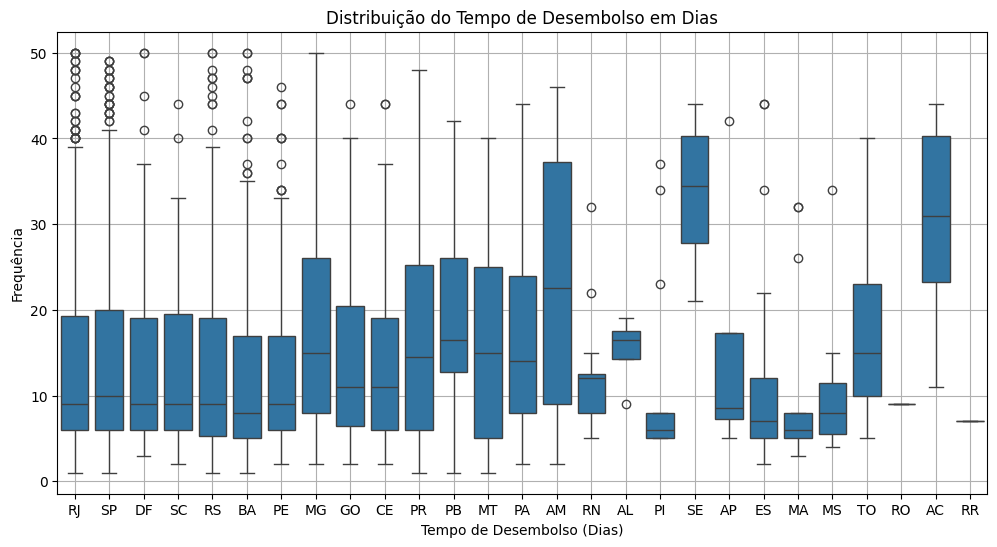

In [ ]:
# Boxplot 
plt.figure(figsize=(12, 6))
sns.boxplot(x='UF', y='TEMPO_DESEMBOLSO', data=outlier_300)
plt.title('Distribuição do Tempo de Desembolso em Dias')
plt.xlabel('Tempo de Desembolso (Dias)')
plt.ylabel('Frequência')
plt.grid(True)

##### Scatterplot - A recorrência de pontos fora da distribuição normal aponta uma alta quantidade de outliers

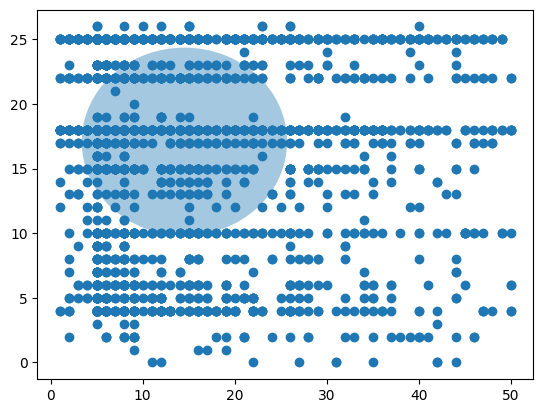

In [ ]:

dado = outlier_300[['TEMPO_DESEMBOLSO', 'UF']]

dado['UF_NUM'] = dado['UF'].astype('category').cat.codes

dado_num = dado[['TEMPO_DESEMBOLSO', 'UF_NUM']].to_numpy()

mean = np.mean(dado_num, 0)
std_dev = np.std(dado_num, 0)

ellipse = patches.Ellipse([mean[0], mean[1]], std_dev[0]*2, std_dev[1]*2, alpha=0.4)

fig, graph = plt.subplots()
graph.add_patch(ellipse)
graph.scatter(dado_num[:,0], dado_num[:,1])
# graph.scatter(mean[0], mean[1])

# graph.set_xlim(0, 1)
# graph.set_ylim(0, 1)



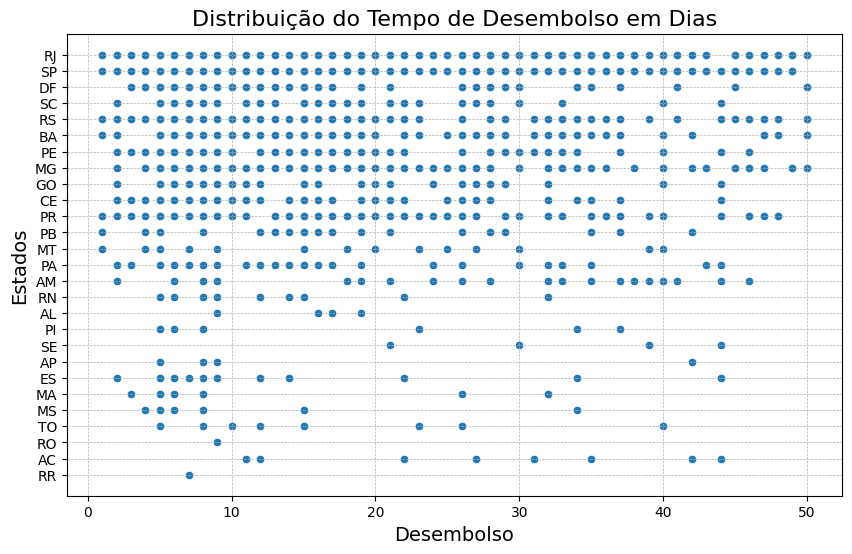

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TEMPO_DESEMBOLSO', y='UF', data=dado)
plt.title('Distribuição do Tempo de Desembolso em Dias', fontsize=16)
plt.xlabel('Desembolso', fontsize=14)
plt.ylabel('Estados', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

##### Histograma - A total assimetria dos dados evidencia uma Distribuição Não Normal, alta quantidade de outliers

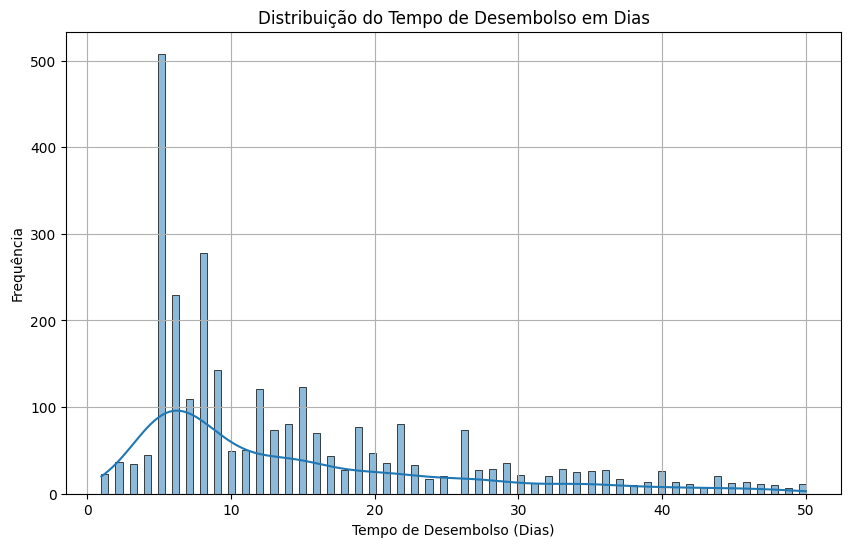

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(dado['TEMPO_DESEMBOLSO'], bins=100, kde=True)
plt.title('Distribuição do Tempo de Desembolso em Dias')
plt.xlabel('Tempo de Desembolso (Dias)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

##### Gráfico Q-Q - útil para verificar se a distribuição dos dados se alinha com a distribuição normal. Se os pontos seguem uma linha reta, os dados são normalmente distribuídos.

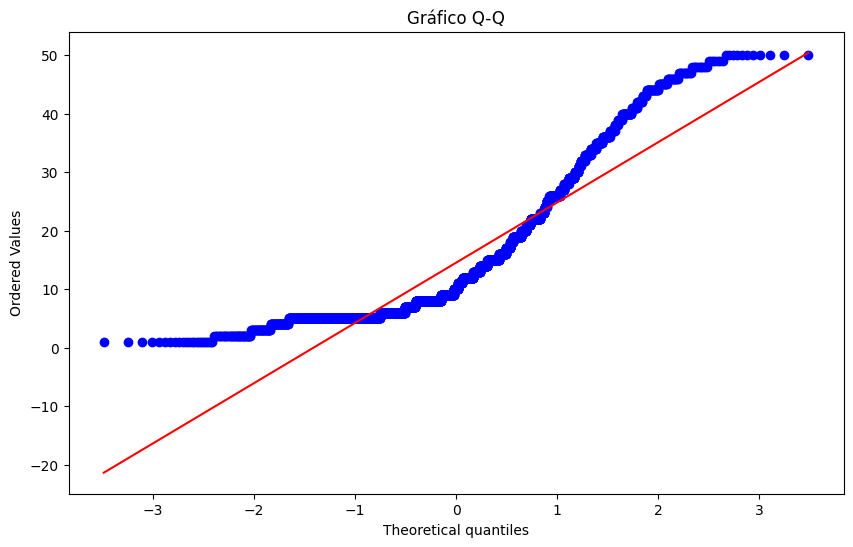

In [ ]:
plt.figure(figsize=(10, 6))
stats.probplot(outlier_300['TEMPO_DESEMBOLSO'], dist="norm", plot=plt)
plt.title('Gráfico Q-Q')
plt.show()

#### Z-score - Adequado para dados com Distribuição Normal, Identificação mais conservadora de outliers (já que o Z-score tende a identificar menos outliers), 

In [ ]:
import numpy as np
from scipy.stats import zscore

fsa_z_score = outlier_300['TEMPO_DESEMBOLSO']
# Calcular Z-scores
z_scores = zscore(fsa_z_score)
outliers = np.abs(z_scores) > 3

# Identificar outliers
fsa_z_score = pd.Series(fsa_z_score)
outliers_identificados = fsa_z_score[outliers]

print("Outliers identificados (Z-score):\n", outliers_identificados.count())

Outliers identificados (Z-score):
 18


#### IQR (Interquartile Range) - Adequado para dados com Distribuição Não Normal, Menos influenciado por valores extremos

In [ ]:
Q1 = np.percentile(fsa_z_score, 25)
Q3 = np.percentile(fsa_z_score, 75)
IQR = Q3 - Q1

# Calcular limites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers
outliers = (fsa_z_score < lower_bound) | (fsa_z_score > upper_bound)

# Criar uma série pandas
fsa_iqr = pd.Series(fsa_z_score)

# Extrair os outliers
outliers_identificados = fsa_iqr[outliers]

print("Outliers identificados (IQR):")
print(outliers_identificados.count())

Outliers identificados (IQR):
104


#### Teste de Shapiro-Wilk - Verifica a normalidade dos dados. Um valor p > 0.05 indica que os dados são normalmente distribuídos.

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(fsa_z_score)
print('Estatística do Teste Shapiro-Wilk:', stat)
print('Valor p:', p)
if p > 0.05:
    print('Os dados parecem seguir uma distribuição normal (não rejeitamos H0)')
else:
    print('Os dados não seguem uma distribuição normal (rejeitamos H0)')

Estatística do Teste Shapiro-Wilk: 0.8471737270265464
Valor p: 2.7626355799568228e-46
Os dados não seguem uma distribuição normal (rejeitamos H0)


#### Teste de Kolmogorov-Smirnov - Compara a distribuição dos dados com uma distribuição normal. Um valor p > 0.05 indica normalidade.

In [ ]:
from scipy.stats import kstest

stat, p = kstest(fsa_z_score, 'norm')
print('Estatística do Teste Kolmogorov-Smirnov:', stat)
print('Valor p:', p)
if p > 0.05:
    print('Os dados parecem seguir uma distribuição normal (não rejeitamos H0)')
else:
    print('Os dados não seguem uma distribuição normal (rejeitamos H0)')

Estatística do Teste Kolmogorov-Smirnov: 0.9776930638964174
Valor p: 0.0
Os dados não seguem uma distribuição normal (rejeitamos H0)


#### Teste de Anderson-Darling - Um teste mais robusto para verificar a normalidade dos dados. Se o valor da estatística for menor que os valores críticos para um nível de significância dado, os dados são normalmente distribuídos.

In [ ]:
from scipy.stats import anderson

result = anderson(fsa_z_score)
print('Estatística do Teste Anderson-Darling:', result.statistic)
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f'Em um nível de significância de {sl}, não podemos rejeitar a hipótese nula (H0).')
    else:
        print(f'Em um nível de significância de {sl}, rejeitamos a hipótese nula (H0).')

Estatística do Teste Anderson-Darling: 151.2182903216808
Em um nível de significância de 15.0, rejeitamos a hipótese nula (H0).
Em um nível de significância de 10.0, rejeitamos a hipótese nula (H0).
Em um nível de significância de 5.0, rejeitamos a hipótese nula (H0).
Em um nível de significância de 2.5, rejeitamos a hipótese nula (H0).
Em um nível de significância de 1.0, rejeitamos a hipótese nula (H0).
